<a href="https://colab.research.google.com/github/Fra3005/Flame-detection/blob/main/Flame_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import os.path
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tqdm import tqdm
import cv2
from skimage.color import rgb2gray
import skimage
from skimage.transform import resize
from keras.models import Sequential, Model
from keras.layers import Dense,Flatten,Conv2D,Activation,Dropout,MaxPooling2D, BatchNormalization
from keras.applications import vgg16
from keras import regularizers
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import StratifiedKFold
from statistics import mean
from keras.utils.vis_utils import plot_model
import seaborn as sns
from IPython.core.pylabtools import figsize

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Utility functions

In [ ]:
#Change directory to upload your dataset
trainD = "/content/drive/MyDrive/Computer Vision/Dataset1/Training/"
testD = "/content/drive/MyDrive/Computer Vision/Dataset1/Test/"

In [ ]:
#Standardization
def prep_fn(img):
    img = img.astype(np.float32) / 255.0
    img = (img - 0.5) * 2
    return img

In [ ]:
#Confusion Matrix
def confusion(test,y_test,model,X):
    y_test_pred = model.predict(test)
    y_test_pred1 = np.argmax(y_test_pred, axis=1)
    names=['No Fire','Fire']
    cm1=confusion_matrix(y_test,y_test_pred1)
    f,ax=plt.subplots(figsize=(10,10))
    sns.heatmap(cm1,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
    plt.title(X, size = 25)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()
    return

In [ ]:
#classification report of Precision, Recall and F1 score
def report(testY, model):
  Y_pred = model.predict(testY)
  y_pred = (Y_pred > 0.5)
  y_pred=np.argmax(y_pred, axis=1)
  labels = testY.classes
  print(classification_report(labels, y_pred))

In [ ]:
#plot images
def plotImages(images_arr):
  fig, axes = plt.subplots(1,10,figsize=(20,20))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img)
    ax.axis("off")
  plt.tight_layout()
  plt.show

In [ ]:
#Get accuracy and Loss
def accuracyLoss(model, testY, trainY):
  loss, accuracy = model.evaluate(testY)
  lossTrain, accuracyTrain = model.evaluate(trainY)
  print("Accuracy on test:", accuracy)
  print("Loss on test:", loss)
  print("------------------")
  print("Accuracy on train:", accuracyTrain)
  print("Loss on train:", lossTrain)

#Preprocessing

In [ ]:
#Preprocessing generator
train_datagen = ImageDataGenerator(preprocessing_function=prep_fn, validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
    trainD,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    subset="training",
    shuffle=True) # set as training data

validation_generator = train_datagen.flow_from_directory(
    trainD, # same directory as training data
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    subset="validation",
    shuffle=True) # set as validation data


test_generator = train_datagen.flow_from_directory(
    testD, # same directory as training data
    target_size=(224, 224),
    batch_size=16,
    class_mode="binary"
    )


Found 2750 images belonging to 2 classes.
Found 686 images belonging to 2 classes.
Found 270 images belonging to 2 classes.


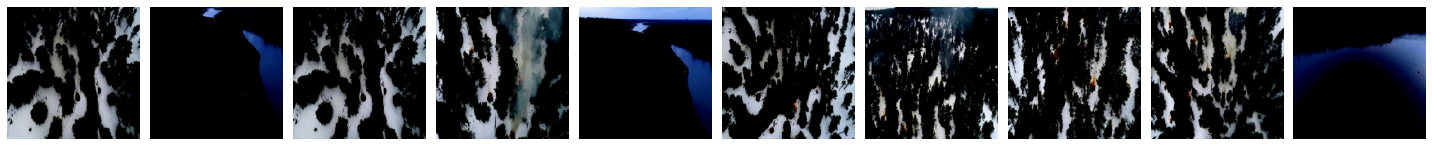

In [ ]:
imgs, labels = next(train_generator)
plotImages(imgs)

#VGG16 Adam
Tranfer learning, use pretrained model for other problems of classification

In [ ]:
def VGG16():
  model = Sequential()
  model.add(tf.keras.applications.VGG16(include_top=False, pooling='max', weights='imagenet'))
  model.add(Flatten())
  model.add(Dropout(0.5))
  model.add(BatchNormalization())
  model.add(Dense(2, activation='softmax'))
  model.layers[0].trainable=False
  return model
  

58900480/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2)                 1026      
                                                                 
Total params: 14,717,762
Trainable params: 2,050
Non-trai

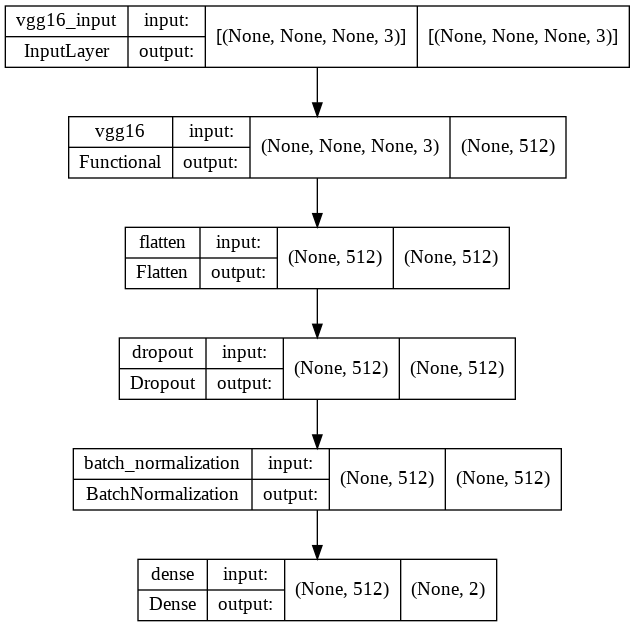

In [ ]:
modelVGG16=VGG16()
modelVGG16.summary()
plot_model(modelVGG16, to_file='modelVGG16_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
modelVGG16.compile(loss="sparse_categorical_crossentropy", optimizer="adam",metrics=["accuracy"])
history = modelVGG16.fit(train_generator, validation_data=validation_generator,epochs=5, shuffle=True)

Epoch 1/5
172/172 [==============================] - 474s 3s/step - loss: 0.3907 - accuracy: 0.8360 - val_loss: 0.1272 - val_accuracy: 0.9810
Epoch 2/5
172/172 [==============================] - 104s 603ms/step - loss: 0.2046 - accuracy: 0.9276 - val_loss: 0.1543 - val_accuracy: 0.9621
Epoch 3/5
172/172 [==============================] - 103s 597ms/step - loss: 0.1603 - accuracy: 0.9378 - val_loss: 0.1572 - val_accuracy: 0.9461
Epoch 4/5
172/172 [==============================] - 102s 594ms/step - loss: 0.1404 - accuracy: 0.9451 - val_loss: 0.2132 - val_accuracy: 0.8790
Epoch 5/5
172/172 [==============================] - 102s 591ms/step - loss: 0.1390 - accuracy: 0.9440 - val_loss: 0.1963 - val_accuracy: 0.9052


In [ ]:
accuracyLoss(modelVGG16, test_generator, train_generator)


172/172 [==============================] - 82s 475ms/step - loss: 0.0332 - accuracy: 0.9924
Accuracy on test: 0.8111110925674438
Loss on test: 0.48556292057037354
------------------
Accuracy on train: 0.9923636317253113
Loss on train: 0.0331803523004055


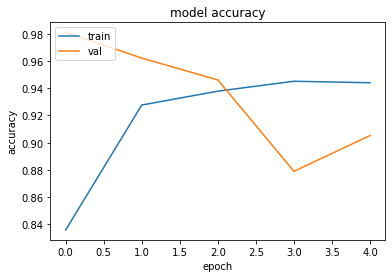

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

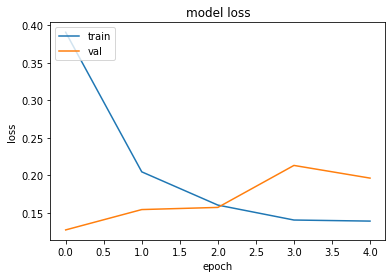

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
report(test_generator, modelVGG16)

              precision    recall  f1-score   support

           0       0.61      0.77      0.68       160
           1       0.46      0.29      0.36       110

    accuracy                           0.57       270
   macro avg       0.54      0.53      0.52       270
weighted avg       0.55      0.57      0.55       270



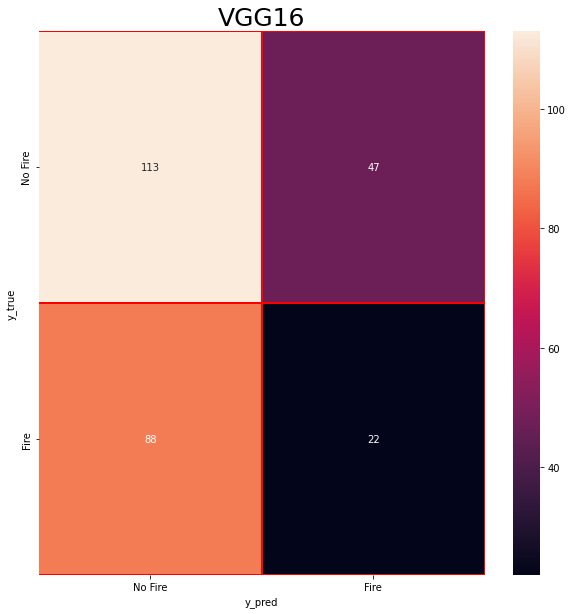

In [ ]:
confusion(test_generator,test_generator.classes,  modelVGG16, "VGG16")

In [ ]:
modelVGG16.save('/content/drive/MyDrive/Computer Vision/Vgg16Fire.h5')
print('Model Saved!')

Model Saved!


In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/Computer Vision/Vgg16Fire.h5')

In [ ]:
img, label = next(test_generator)
def prepare(filepath):
  IMG_SIZE = 224
  img_array = cv2.imread(filepath)
  new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
  return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)


prediction = model.predict([prepare('/content/drive/MyDrive/Computer Vision/Dataset1/Test/Fire/resized_test_fire_frame1086.jpg')])
print((prediction))

[[1. 0.]]


#Vgg19 Adam
Tranfer learning, use pretrained model for other problems of classification

In [ ]:
def VGG19():
  model19 = Sequential()
  model19.add(tf.keras.applications.VGG19(include_top=False, pooling='max', weights='imagenet'))
  model19.add(Flatten())
  model19.add(Dropout(0.5))
  model19.add(BatchNormalization())
  model19.add(Dense(2, activation='softmax'))
  model19.layers[0].trainable=False
  return model19

80150528/80134624 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 20,027,458
Trainable params: 2,050
Non-tr

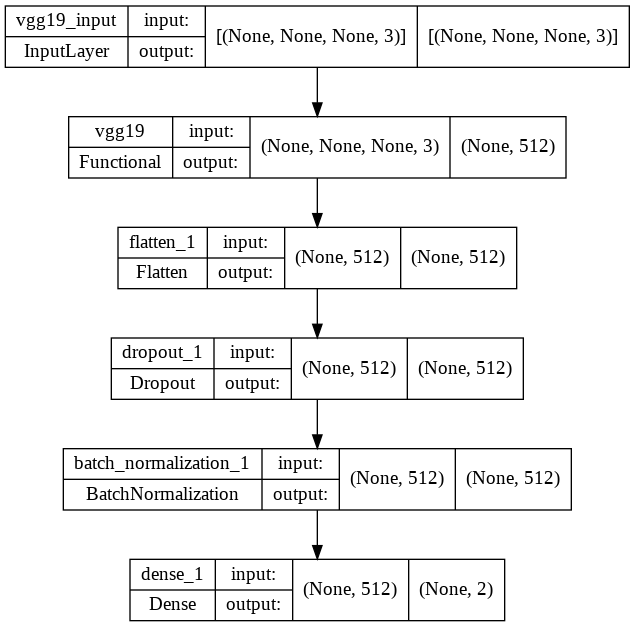

In [ ]:
model19=VGG19()
model19.summary()
plot_model(model19, to_file='modelVGG19_plot.png', show_shapes=True, show_layer_names=True)


In [ ]:
model19.compile(loss="sparse_categorical_crossentropy", optimizer="adam",metrics=["accuracy"])
history = model19.fit(train_generator,validation_data=validation_generator,epochs=5)

Epoch 1/5
172/172 [==============================] - 128s 742ms/step - loss: 0.3987 - accuracy: 0.8382 - val_loss: 0.2299 - val_accuracy: 0.8717
Epoch 2/5
172/172 [==============================] - 127s 741ms/step - loss: 0.2110 - accuracy: 0.9236 - val_loss: 0.2954 - val_accuracy: 0.8615
Epoch 3/5
172/172 [==============================] - 128s 744ms/step - loss: 0.1621 - accuracy: 0.9422 - val_loss: 0.3189 - val_accuracy: 0.8703
Epoch 4/5
172/172 [==============================] - 127s 742ms/step - loss: 0.1473 - accuracy: 0.9440 - val_loss: 0.2807 - val_accuracy: 0.8761
Epoch 5/5
172/172 [==============================] - 127s 738ms/step - loss: 0.1199 - accuracy: 0.9531 - val_loss: 0.3571 - val_accuracy: 0.8717


In [ ]:
accuracyLoss(model19, test_generator, train_generator)


172/172 [==============================] - 102s 591ms/step - loss: 0.0347 - accuracy: 0.9913
Accuracy on test: 0.7111111283302307
Loss on test: 0.8565307855606079
------------------
Accuracy on train: 0.9912727475166321
Loss on train: 0.03467431291937828


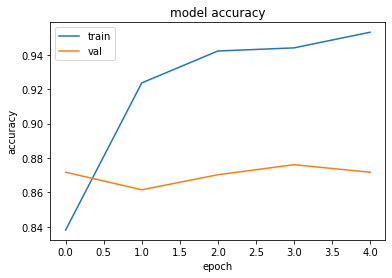

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

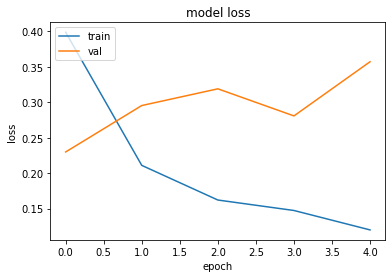

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
report(test_generator, model19)

              precision    recall  f1-score   support

           0       0.60      0.72      0.66       160
           1       0.42      0.29      0.34       110

    accuracy                           0.55       270
   macro avg       0.51      0.51      0.50       270
weighted avg       0.53      0.55      0.53       270



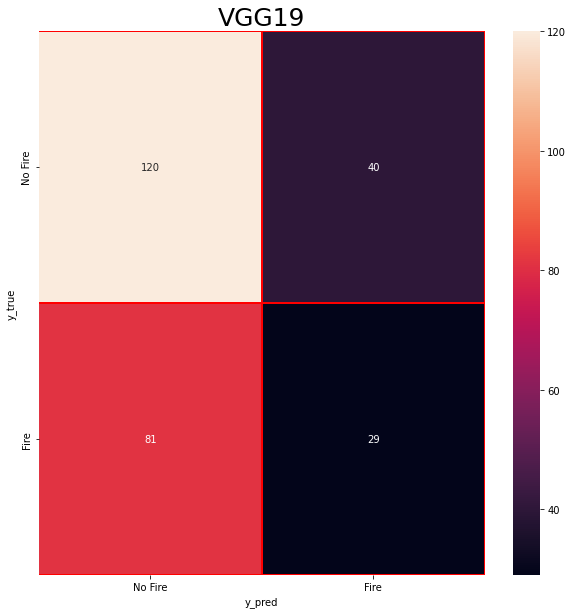

In [ ]:
confusion(test_generator,test_generator.classes,  modelVGG16, "VGG19")


In [ ]:
model19.save('/content/drive/MyDrive/Computer Vision/Vgg19Fire.h5')
print('Model Saved!')

Model Saved!


# InceptionV3 Adam
Tranfer learning, use pretrained model for other problems of classification

In [ ]:
def InceptionV3():
  inceprion_model = Sequential()
  pretrained_model= tf.keras.applications.InceptionV3(include_top=False,
                   pooling='max',
                   weights='imagenet',
                   input_shape=(224,224,3))
  for layer in pretrained_model.layers:
        layer.trainable=False

  inceprion_model.add(pretrained_model)
  inceprion_model.add(Flatten())
  inceprion_model.add(Dropout(0.5))
  inceprion_model.add(BatchNormalization())
  inceprion_model.add(Dense(2, activation='softmax'))
  return inceprion_model

87924736/87910968 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 batch_normalization_96 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 2)                 4098      
                                                                 
Total params: 21,815,074
Trainable params: 8,194
Non-tr

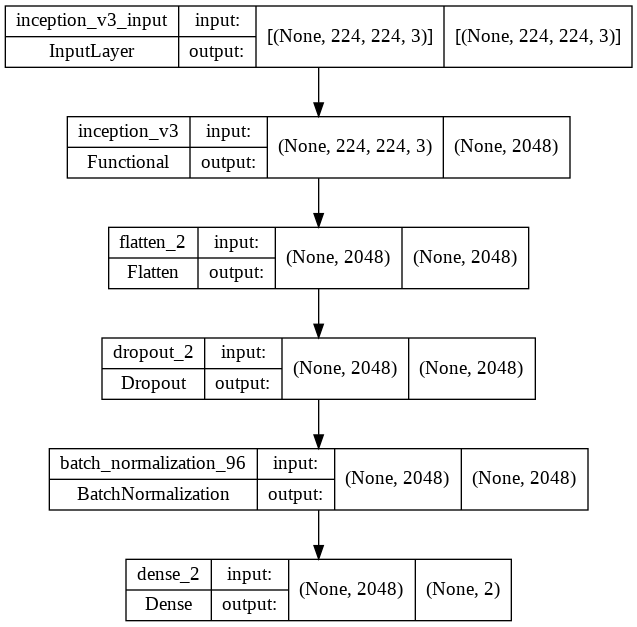

In [ ]:
inceprion_model = InceptionV3()
inceprion_model.summary()
plot_model(inceprion_model, to_file='modelInceptionV3_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
inceprion_model.compile(optimizer="adam",loss='sparse_categorical_crossentropy',metrics=['accuracy'])

history = inceprion_model.fit(train_generator, validation_data=validation_generator, epochs=5)

Epoch 1/5
172/172 [==============================] - 49s 264ms/step - loss: 0.1917 - accuracy: 0.9222 - val_loss: 0.1146 - val_accuracy: 0.9257
Epoch 2/5
172/172 [==============================] - 48s 278ms/step - loss: 0.0689 - accuracy: 0.9731 - val_loss: 0.2750 - val_accuracy: 0.8732
Epoch 3/5
172/172 [==============================] - 50s 293ms/step - loss: 0.0621 - accuracy: 0.9785 - val_loss: 0.1357 - val_accuracy: 0.9198
Epoch 4/5
172/172 [==============================] - 51s 296ms/step - loss: 0.0420 - accuracy: 0.9840 - val_loss: 0.1541 - val_accuracy: 0.9169
Epoch 5/5
172/172 [==============================] - 50s 292ms/step - loss: 0.0461 - accuracy: 0.9822 - val_loss: 0.2682 - val_accuracy: 0.8863


In [ ]:
accuracyLoss(inceprion_model, test_generator, train_generator)

172/172 [==============================] - 39s 224ms/step - loss: 0.0011 - accuracy: 1.0000
Accuracy on test: 0.8259259462356567
Loss on test: 0.41706594824790955
------------------
Accuracy on train: 1.0
Loss on train: 0.001114778220653534


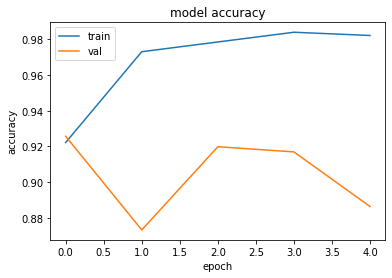

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

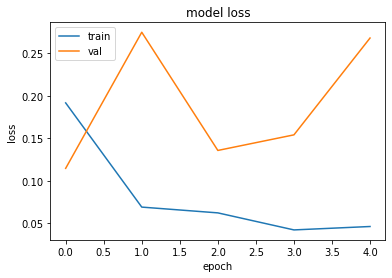

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
report(test_generator, inceprion_model)


              precision    recall  f1-score   support

           0       0.57      0.57      0.57       160
           1       0.38      0.37      0.37       110

    accuracy                           0.49       270
   macro avg       0.47      0.47      0.47       270
weighted avg       0.49      0.49      0.49       270



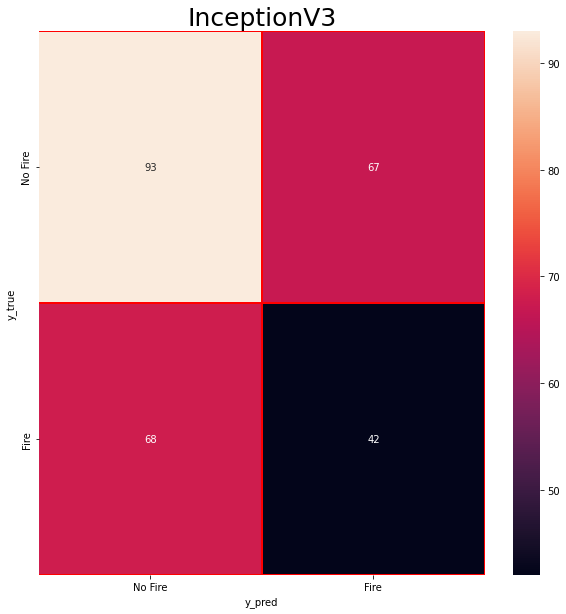

In [ ]:
confusion(test_generator,test_generator.classes, inceprion_model, "InceptionV3")


In [ ]:
inceprion_model.save('/content/drive/MyDrive/Computer Vision/InceptionV3.h5')
print('Model Saved!')

Model Saved!


#InceptionV3 sgd
Tranfer learning, use pretrained model for other problems of classification

In [ ]:
def inceptionV3():
  inception_model = Sequential()
  pretrained_model= tf.keras.applications.InceptionV3(include_top=False,
                   pooling='max',
                   weights='imagenet',
                   input_shape=(224,224,3))
  for layer in pretrained_model.layers:
        layer.trainable=False

  inception_model.add(pretrained_model)
  inception_model.add(Flatten())
  inception_model.add(Dropout(0.5))
  inception_model.add(BatchNormalization())
  inception_model.add(Dense(2, activation='softmax'))
  return inception_model

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 dropout_3 (Dropout)         (None, 2048)              0         
                                                                 
 batch_normalization_191 (Ba  (None, 2048)             8192      
 tchNormalization)                                               
                                                                 
 dense_3 (Dense)             (None, 2)                 4098      
                                                                 
Total params: 21,815,074
Trainable params: 8,194
Non-trainable params: 21,806,880
______________________________________

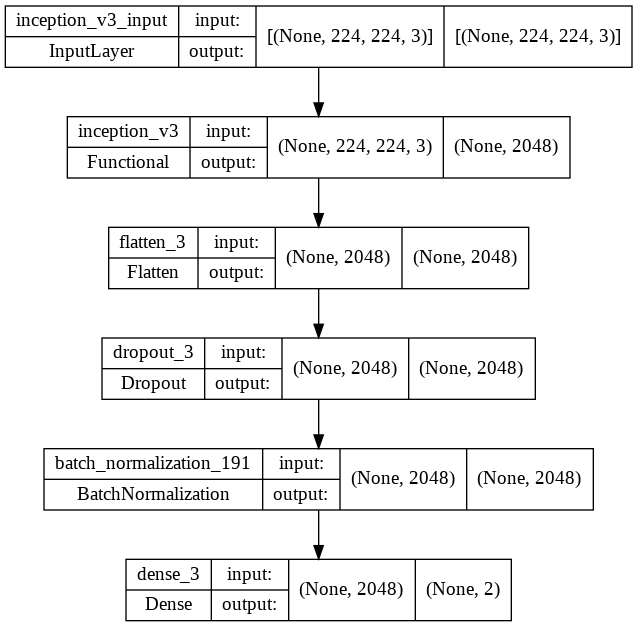

In [ ]:
inception_model = inceptionV3()
inception_model.summary()
plot_model(inception_model, to_file='modelInceptionV3_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
inception_model.compile(optimizer="sgd",loss='sparse_categorical_crossentropy',metrics=['accuracy'])

history = inception_model.fit(train_generator, validation_data=validation_generator, epochs=5)

Epoch 1/5
172/172 [==============================] - 43s 228ms/step - loss: 0.2165 - accuracy: 0.9160 - val_loss: 0.2249 - val_accuracy: 0.8980
Epoch 2/5
172/172 [==============================] - 41s 240ms/step - loss: 0.0898 - accuracy: 0.9673 - val_loss: 0.2210 - val_accuracy: 0.8936
Epoch 3/5
172/172 [==============================] - 38s 222ms/step - loss: 0.0645 - accuracy: 0.9767 - val_loss: 0.1848 - val_accuracy: 0.8994
Epoch 4/5
172/172 [==============================] - 39s 224ms/step - loss: 0.0635 - accuracy: 0.9771 - val_loss: 0.1831 - val_accuracy: 0.9009
Epoch 5/5
172/172 [==============================] - 38s 224ms/step - loss: 0.0495 - accuracy: 0.9829 - val_loss: 0.2431 - val_accuracy: 0.8921


In [ ]:
accuracyLoss(inception_model, test_generator, train_generator)

172/172 [==============================] - 29s 166ms/step - loss: 0.0036 - accuracy: 1.0000
Accuracy on test: 0.7222222089767456
Loss on test: 0.582794189453125
------------------
Accuracy on train: 1.0
Loss on train: 0.003628960344940424


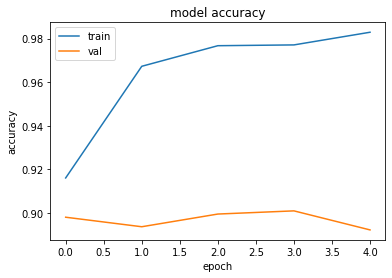

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

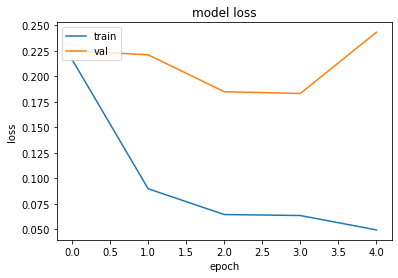

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
report(test_generator, inception_model)


              precision    recall  f1-score   support

           0       0.59      0.42      0.49       160
           1       0.41      0.58      0.48       110

    accuracy                           0.49       270
   macro avg       0.50      0.50      0.49       270
weighted avg       0.52      0.49      0.49       270



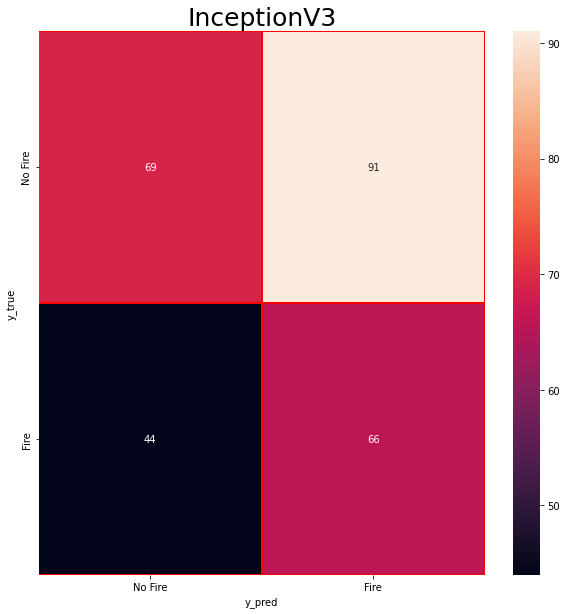

In [ ]:
confusion(test_generator,test_generator.classes, inception_model, "InceptionV3")


In [ ]:
inception_model.save('/content/drive/MyDrive/Computer Vision/InceptionV3.h5')
print('Model Saved!')

Model Saved!


#VGG16 sgd
Tranfer learning, use pretrained model for other problems of classification

In [ ]:
def VGG16():
  model = Sequential()
  model.add(tf.keras.applications.VGG16(include_top=False, pooling='max', weights='imagenet'))
  model.add(Flatten())
  model.add(Dropout(0.5))
  model.add(BatchNormalization())
  model.add(Dense(2, activation='softmax'))
  model.layers[0].trainable=False
  return model
  

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten_4 (Flatten)         (None, 512)               0         
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 batch_normalization_192 (Ba  (None, 512)              2048      
 tchNormalization)                                               
                                                                 
 dense_4 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 14,717,762
Trainable params: 2,050
Non-trainable params: 14,715,712
______________________________________

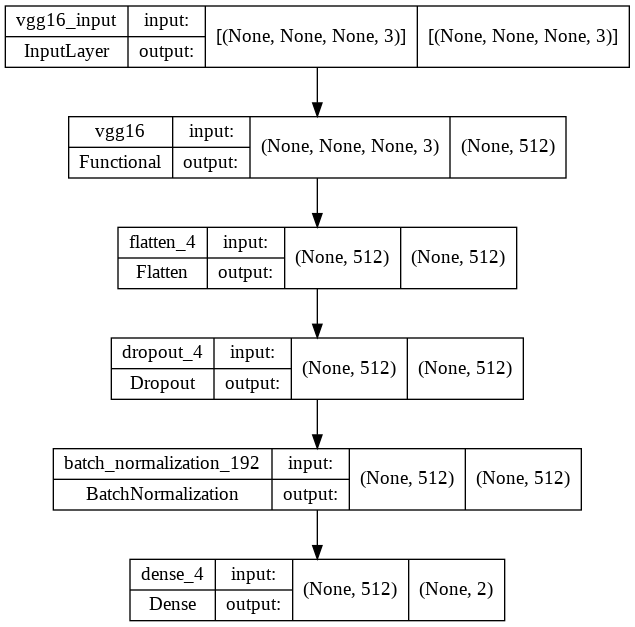

In [ ]:
modelVGG16=VGG16()
modelVGG16.summary()
plot_model(modelVGG16, to_file='modelVGG16_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
modelVGG16.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",metrics=["accuracy"])
history = modelVGG16.fit(train_generator, validation_data=validation_generator,epochs=5, shuffle=True)

Epoch 1/5
172/172 [==============================] - 105s 608ms/step - loss: 0.3514 - accuracy: 0.8495 - val_loss: 0.1370 - val_accuracy: 0.9475
Epoch 2/5
172/172 [==============================] - 105s 611ms/step - loss: 0.2105 - accuracy: 0.9189 - val_loss: 0.1194 - val_accuracy: 0.9694
Epoch 3/5
172/172 [==============================] - 105s 611ms/step - loss: 0.1705 - accuracy: 0.9371 - val_loss: 0.1186 - val_accuracy: 0.9694
Epoch 4/5
172/172 [==============================] - 104s 607ms/step - loss: 0.1464 - accuracy: 0.9473 - val_loss: 0.1249 - val_accuracy: 0.9534
Epoch 5/5
172/172 [==============================] - 104s 608ms/step - loss: 0.1381 - accuracy: 0.9535 - val_loss: 0.1164 - val_accuracy: 0.9636


In [ ]:
accuracyLoss(modelVGG16, test_generator, train_generator)


172/172 [==============================] - 83s 484ms/step - loss: 0.0507 - accuracy: 0.9855
Accuracy on test: 0.7666666507720947
Loss on test: 0.5182918906211853
------------------
Accuracy on train: 0.9854545593261719
Loss on train: 0.050672292709350586


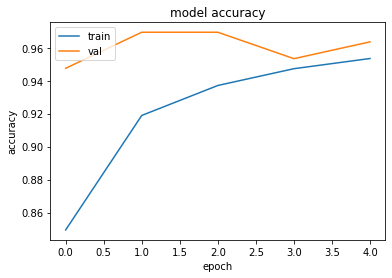

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

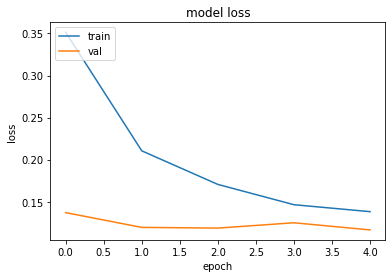

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
report(test_generator, modelVGG16)

              precision    recall  f1-score   support

           0       0.61      0.78      0.68       160
           1       0.46      0.27      0.34       110

    accuracy                           0.57       270
   macro avg       0.54      0.53      0.51       270
weighted avg       0.55      0.57      0.55       270



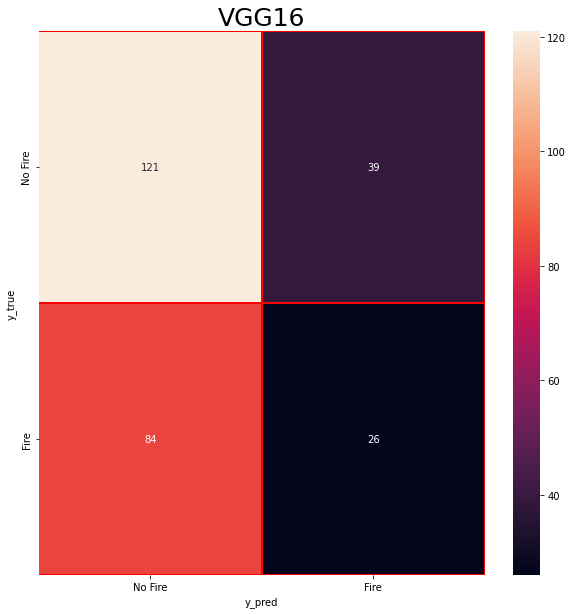

In [ ]:
confusion(test_generator,test_generator.classes,  modelVGG16, "VGG16")

In [ ]:
modelVGG16.save('/content/drive/MyDrive/Computer Vision/Vgg16Fire.h5')
print('Model Saved!')

Model Saved!


In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/Computer Vision/Vgg16Fire.h5')

In [ ]:
img, label = next(test_generator)
def prepare(filepath):
  IMG_SIZE = 224
  img_array = cv2.imread(filepath)
  new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
  return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)


prediction = model.predict([prepare('/content/drive/MyDrive/Computer Vision/Dataset1/Test/Fire/resized_test_fire_frame1086.jpg')])
print((prediction))

[[1. 0.]]


#Vgg19 sgd
Tranfer learning, use pretrained model for other problems of classification

In [ ]:
def VGG19():
  model19 = Sequential()
  model19.add(tf.keras.applications.VGG19(include_top=False, pooling='max', weights='imagenet'))
  model19.add(Flatten())
  model19.add(Dropout(0.5))
  model19.add(BatchNormalization())
  model19.add(Dense(2, activation='softmax'))
  model19.layers[0].trainable=False
  return model19

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 flatten_5 (Flatten)         (None, 512)               0         
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 batch_normalization_193 (Ba  (None, 512)              2048      
 tchNormalization)                                               
                                                                 
 dense_5 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 20,027,458
Trainable params: 2,050
Non-trainable params: 20,025,408
______________________________________

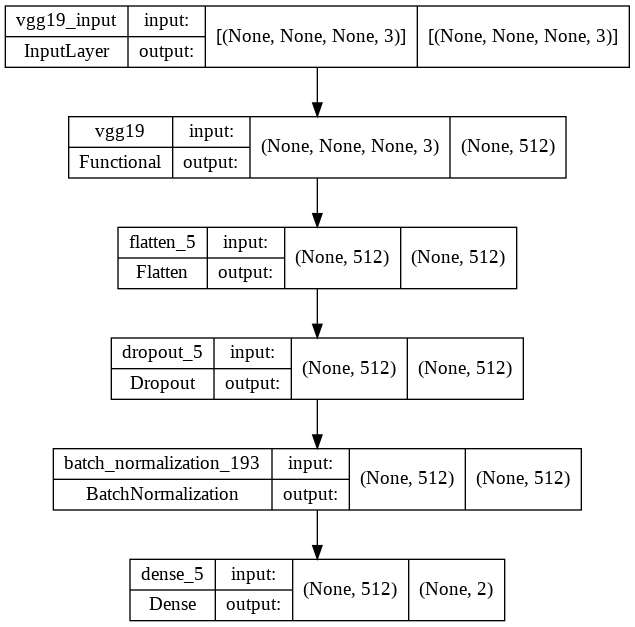

In [ ]:
model19=VGG19()
model19.summary()
plot_model(model19, to_file='modelVGG19_plot.png', show_shapes=True, show_layer_names=True)


In [ ]:
model19.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",metrics=["accuracy"])
history = model19.fit(train_generator,validation_data=validation_generator,epochs=5)

Epoch 1/5
172/172 [==============================] - 131s 759ms/step - loss: 0.3543 - accuracy: 0.8542 - val_loss: 0.1788 - val_accuracy: 0.8994
Epoch 2/5
172/172 [==============================] - 131s 765ms/step - loss: 0.1993 - accuracy: 0.9240 - val_loss: 0.2353 - val_accuracy: 0.8732
Epoch 3/5
172/172 [==============================] - 131s 764ms/step - loss: 0.1810 - accuracy: 0.9305 - val_loss: 0.2684 - val_accuracy: 0.8732
Epoch 4/5
172/172 [==============================] - 131s 761ms/step - loss: 0.1603 - accuracy: 0.9382 - val_loss: 0.3008 - val_accuracy: 0.8717
Epoch 5/5
172/172 [==============================] - 130s 759ms/step - loss: 0.1337 - accuracy: 0.9527 - val_loss: 0.3215 - val_accuracy: 0.8717


In [ ]:
accuracyLoss(model19, test_generator, train_generator)


172/172 [==============================] - 105s 610ms/step - loss: 0.0453 - accuracy: 0.9880
Accuracy on test: 0.7814815044403076
Loss on test: 0.5869842767715454
------------------
Accuracy on train: 0.9879999756813049
Loss on train: 0.04533137008547783


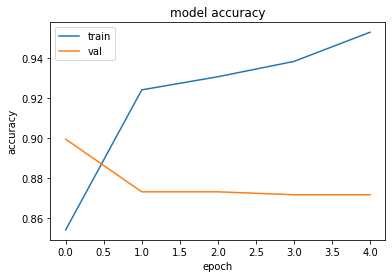

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

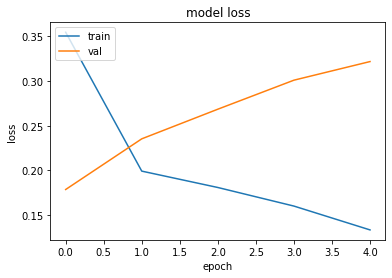

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
report(test_generator, model19)

              precision    recall  f1-score   support

           0       0.59      0.74      0.66       160
           1       0.39      0.24      0.29       110

    accuracy                           0.54       270
   macro avg       0.49      0.49      0.47       270
weighted avg       0.51      0.54      0.51       270



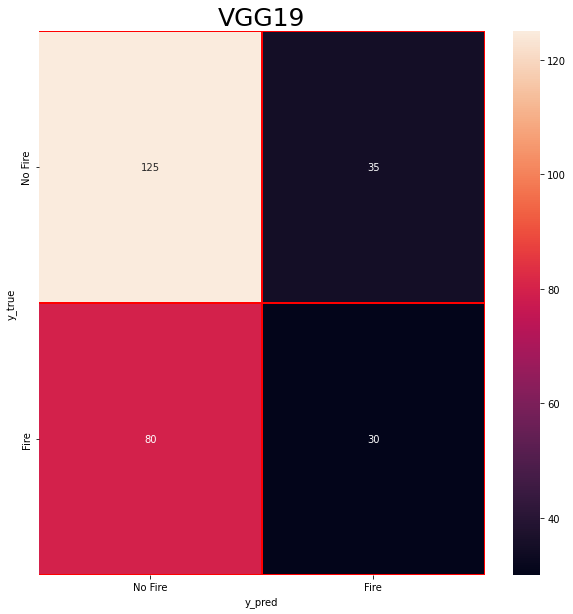

In [ ]:
confusion(test_generator,test_generator.classes,  modelVGG16, "VGG19")


In [ ]:
model19.save('/content/drive/MyDrive/Computer Vision/Vgg19Fire.h5')
print('Model Saved!')

Model Saved!


#-------------------------------Yolo Detection----------------------------------


#Yolov5 Requirements

In [ ]:
!pip install wandb

!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt  # install

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 5.0 MB/s 
     |████████████████████████████████| 181 kB 76.8 MB/s 
     |████████████████████████████████| 158 kB 70.0 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
     |████████████████████████████████| 157 kB 83.4 MB/s 
     |████████████████████████████████| 157 kB 83.6 MB/s 
     |████████████████████████████████| 157 kB 82.9 MB/s 
     |████████████████████████████████| 157 kB 72.0 MB/s 
     |████████████████████████████████| 157 kB 77.1 MB/s 
     |████████████████████████████████| 157 kB 82.2 MB/s 
     |████████████████████████████████| 157 kB 80.8 MB/s 
     |████████████████████████████████| 156 kB 79.1 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=c67f660e66582383341b99501638e27eee3f65af1ffc629e6b1b4802d22a530e
  Stored in directory: /root/.cache/pip/wheels/3e/31/

In [ ]:
!pip install -r requirements.txt
from yolov5 import utils
import utils

display = utils.notebook_init() 
from utils.plots import plot_results

YOLOv5 🚀 v6.2-109-g23701ea Python-3.7.13 torch-1.12.1+cu113 CPU


Setup complete ✅ (40 CPUs, 35.2 GB RAM, 37.6/225.8 GB disk)


In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="lah83GJaFa4Fi8dbbW1b")
project = rf.workspace("computer-vision-kqeh1").project("fire-detection-dz3xj")
dataset = project.version(4).download("yolov5")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 145 kB 4.9 MB/s 
     |████████████████████████████████| 178 kB 49.9 MB/s 
     |████████████████████████████████| 1.1 MB 78.7 MB/s 
     |████████████████████████████████| 67 kB 5.7 MB/s 
     |████████████████████████████████| 54 kB 2.6 MB/s 
     |████████████████████████████████| 138 kB 77.2 MB/s 
     |████████████████████████████████| 62 kB 1.4 MB/s 
  Created wheel for roboflow: filename=roboflow-0.2.14-py3-none-any.whl size=24837 sha256=e1fc30b6a741924a8aebdef99607d1775bd77349cb657b15721dca59a073ac0b
  Stored in directory: /root/.cache/pip/wheels/c7/84/36/a6a32c749ead923690d15d20443fb53fa2fe10beaa408f371b
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=9da5a88df0261de17147336fa57c5b3ced0374eec31489fdacc114e931db67dc
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Fire-detection-4 in yolov5pytorch:: 100%|██████████| 3028/3028 [00:00<00:00, 7754.78it/s]


#Train of Yolo Model

In [ ]:
!python train.py  --batch 32 --epochs 150 --data '/content/yolov5/Fire-detection-4/data.yaml' --weights yolov5s.pt --hyp '/content/yolov5/data/hyps/hyp.scratch-high.yaml' 

wandb: Currently logged in as: francescodidio. Use `wandb login --relogin` to force relogin
train: weights=yolov5s.pt, cfg=, data=/content/yolov5/Fire-detection-4/data.yaml, hyp=/content/yolov5/data/hyps/hyp.scratch-high.yaml, epochs=150, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-359-g628c05c Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum

#Validation Model

In [ ]:
!python val.py --weights "/content/yolov5/runs/train/exp/weights/best.pt" --data '/content/yolov5/Fire-detection-4/data.yaml'

val: data=/content/yolov5/Fire-detection-4/data.yaml, weights=['/content/yolov5/runs/train/exp/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.1-359-g628c05c Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning '/content/yolov5/Fire-detection-4/valid/labels.cache' images and labels... 80 found, 0 missing, 4 empty, 0 corrupt: 100% 80/80 [00:00<?, ?it/s]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100% 3/3 [00:02<00:00,  1.15it/s]
                 all         80        417      0.835      0.762      0.799      0.356
Speed: 0.6ms pre-process, 3.4ms inference, 1.7ms NMS per

#Detect fire in image

In [ ]:
!python detect.py --weights "/content/drive/MyDrive/Computer Vision/best.pt" --conf 0.5 --source '/content/drive/MyDrive/Computer Vision/Test yolo/Originale1.jpg' --hide-label

detect: weights=['/content/drive/MyDrive/Computer Vision/best.pt'], source=/content/drive/MyDrive/Computer Vision/Test yolo/Originale1.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.8, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v6.2-109-g23701ea Python-3.7.13 torch-1.12.1+cu113 CPU

Fusing layers... 
Model summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 /content/drive/MyDrive/Computer Vision/Test yolo/Originale1.jpg: 640x640 1 Fire, 99.3ms
Speed: 1.7ms pre-process, 99.3ms inference, 1.0ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp2


In [ ]:
def fireDetection(Original, Test):
  fig = plt.figure(figsize=(15, 10))
  
  # setting values to rows and column variables
  rows = 2
  columns = 2
  
  # reading images
  Image1 = cv2.imread(Original)
  Image2 = cv2.imread(Test)

  # Adds a subplot at the 1st position
  fig.add_subplot(rows, columns, 1)
  
  # showing image
  plt.imshow(Image1)
  plt.axis('off')
  plt.title("Original")
  
  # Adds a subplot at the 2nd position
  fig.add_subplot(rows, columns, 2)
  
  # showing image
  plt.imshow(Image2)
  plt.axis('off')
  plt.title("Test")
  



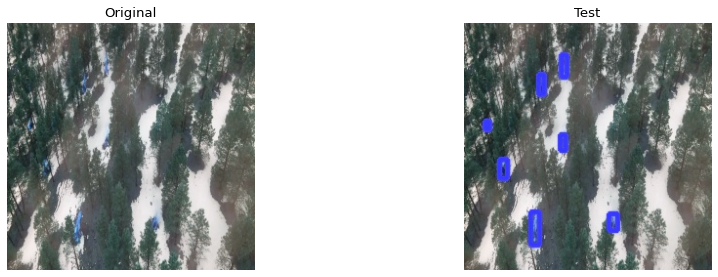

In [ ]:
Original = '/content/drive/MyDrive/Computer Vision/Test yolo/Originale1.jpg'
Test = '/content/drive/MyDrive/Computer Vision/Test yolo/Test1.jpg'
fireDetection(Original, Test)

* Second Test

In [ ]:
!python detect.py --weights "/content/drive/MyDrive/Computer Vision/best.pt" --conf 0.5 --source '/content/drive/MyDrive/Computer Vision/Test yolo/Originale2.jpg' --hide-label


detect: weights=['/content/drive/MyDrive/Computer Vision/best.pt'], source=/content/drive/MyDrive/Computer Vision/Test yolo/Originale2.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=True, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-376-g48a8531 Python-3.7.13 torch-1.12.0+cu113 CPU

Fusing layers... 
Model summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 /content/drive/MyDrive/Computer Vision/Test yolo/Originale2.jpg: 640x640 2 Fires, Done. (0.104s)
Speed: 1.9ms pre-process, 104.3ms inference, 1.2ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp3


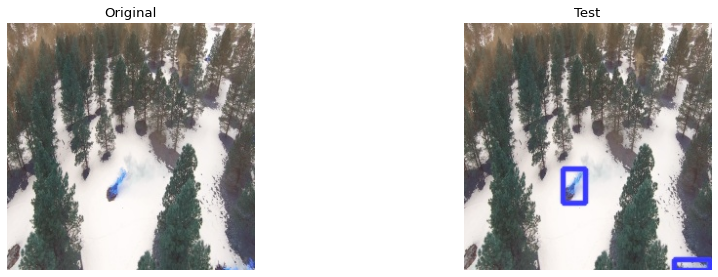

In [ ]:
Original2 = '/content/drive/MyDrive/Computer Vision/Test yolo/Originale2.jpg'
Test2 = '/content/drive/MyDrive/Computer Vision/Test yolo/Test2.jpg'

fireDetection(Original2, Test2)

* Third Test

In [ ]:
!python detect.py --weights "/content/drive/MyDrive/Computer Vision/best.pt" --conf 0.5 --source '/content/drive/MyDrive/Computer Vision/Test yolo/Originale3.jpg' --hide-label


detect: weights=['/content/drive/MyDrive/Computer Vision/best.pt'], source=/content/drive/MyDrive/Computer Vision/Test yolo/Originale3.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=True, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-376-g48a8531 Python-3.7.13 torch-1.12.0+cu113 CPU

Fusing layers... 
Model summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 /content/drive/MyDrive/Computer Vision/Test yolo/Originale3.jpg: 384x640 1 Fire, Done. (0.068s)
Speed: 0.8ms pre-process, 67.7ms inference, 1.0ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp4


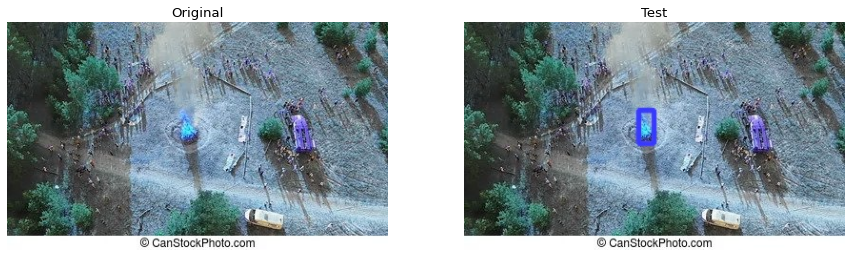

In [ ]:
Original3 = '/content/drive/MyDrive/Computer Vision/Test yolo/Originale3.jpg'
Test3 = '/content/drive/MyDrive/Computer Vision/Test yolo/Test3.jpg'

fireDetection(Original3, Test3)

#Save model

In [ ]:
!zip -r '/content/drive/MyDrive/Computer Vision/yoloBestModel.zip' '/content/yolov5/runs/train/exp2'

  adding: content/yolov5/runs/train/exp2/ (stored 0%)
  adding: content/yolov5/runs/train/exp2/P_curve.png (deflated 19%)
  adding: content/yolov5/runs/train/exp2/results.png (deflated 10%)
  adding: content/yolov5/runs/train/exp2/results.csv (deflated 85%)
  adding: content/yolov5/runs/train/exp2/events.out.tfevents.1659600491.f6fef2c98e44.1684.0 (deflated 45%)
  adding: content/yolov5/runs/train/exp2/train_batch0.jpg (deflated 4%)
  adding: content/yolov5/runs/train/exp2/confusion_matrix.png (deflated 40%)
  adding: content/yolov5/runs/train/exp2/val_batch1_pred.jpg (deflated 5%)
  adding: content/yolov5/runs/train/exp2/hyp.yaml (deflated 44%)
  adding: content/yolov5/runs/train/exp2/val_batch0_labels.jpg (deflated 4%)
  adding: content/yolov5/runs/train/exp2/PR_curve.png (deflated 21%)
  adding: content/yolov5/runs/train/exp2/val_batch0_pred.jpg (deflated 4%)
  adding: content/yolov5/runs/train/exp2/labels.jpg (deflated 19%)
  adding: content/yolov5/runs/train/exp2/opt.yaml (deflate